### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between input current configuration between output magnetic field 

In [40]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
from early_stopping import EarlyStopping

if torch.cuda.device_count():
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Using cpu')

Good to go


In [44]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
train_file_num = 50
data = ReadCurrentAndField (foldername,filepattern)

fileList = glob.glob(foldername+filepattern)
position = data[:,0:-1:20,:15].reshape(-1,15)
Bfield = data[:,0:-1:20,15:].reshape(-1,3)
print(fileList)
print(data.shape)
print('position shape', position.shape)
print('Bfield shape', Bfield.shape)


['./Data\\MagneticField0.txt', './Data\\MagneticField1.txt', './Data\\MagneticField10.txt', './Data\\MagneticField100.txt', './Data\\MagneticField101.txt', './Data\\MagneticField102.txt', './Data\\MagneticField103.txt', './Data\\MagneticField104.txt', './Data\\MagneticField105.txt', './Data\\MagneticField106.txt', './Data\\MagneticField107.txt', './Data\\MagneticField108.txt', './Data\\MagneticField109.txt', './Data\\MagneticField11.txt', './Data\\MagneticField110.txt', './Data\\MagneticField111.txt', './Data\\MagneticField112.txt', './Data\\MagneticField113.txt', './Data\\MagneticField114.txt', './Data\\MagneticField115.txt', './Data\\MagneticField116.txt', './Data\\MagneticField117.txt', './Data\\MagneticField118.txt', './Data\\MagneticField119.txt', './Data\\MagneticField12.txt', './Data\\MagneticField120.txt', './Data\\MagneticField121.txt', './Data\\MagneticField122.txt', './Data\\MagneticField123.txt', './Data\\MagneticField124.txt', './Data\\MagneticField125.txt', './Data\\Magne

In [63]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop import train_part_v1


batch_size = 128
# construct dataset
dataset = eMNS_Dataset(
    train_x=position,
    train_y=Bfield
)


###############################################
# Config the neural network
###############################################
num_input = 15
num_output = 3
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)
epochs = 50
learning_rate_decay = .1
learning_rates = [1e-3]
schedule = []
weight_decays = [0]

train_percents = np.arange(0.1,1.0,0.1)
RMSE_history_end = np.zeros(len(train_percents))
RMSE_val_history_end = np.zeros(len(train_percents))
loss_history_end = np.zeros(len(train_percents))
iter_history_end = np.zeros(len(train_percents))
loss_val_history_end = np.zeros(len(train_percents))
train_stop_epoch = np.zeros(len(train_percents))

################################################
# Train the neural network
################################################
index=0
for train_percent in train_percents:
    epoch_stop = 0
    print('train_percent',train_percent)
    for learning_rate in learning_rates:
        for weight_decay in weight_decays:

            # split the dataset to train, validation, test
            train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_percent*0.9,train_percent*0.1,1.0-train_percent])

            #Using Dataloader for batch train
            train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
            valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)
            test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

            fc_network.apply(weight_init)
            optimizer = torch.optim.Adam([{'params':fc_network.parameters()}], lr=learning_rate, weight_decay= weight_decay)
            RMSE_history, RMSE_val_history, loss_history, iter_history, loss_val_history,epoch_stop = train_part_v1(model=fc_network, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, epochs=epochs, learning_rate_decay=learning_rate_decay, schedule=schedule, weight_decay=weight_decay, verbose=False, device=device)
    
    #save RMSE and loss after early stopping
    RMSE_history_end[index] = RMSE_history[epoch_stop]
    RMSE_val_history_end[index]= RMSE_val_history[epoch_stop]
    loss_history_end[index] = loss_history[epoch_stop]
    iter_history_end[index] = iter_history[epoch_stop]
    loss_val_history_end[index] = loss_val_history[epoch_stop]
    index=index+1
    print('training stop at epoch:',epoch_stop)


train_percent 0.1
Epoch 0, Iteration 326, loss = 0.1579
Got RMSE 0.3434410095214844
Got RMSE 0.33693650364875793

Validation loss decreased (inf --> 0.157936).  Saving model ...
Epoch 1, Iteration 652, loss = 0.0057
Got RMSE 0.08255292475223541
Got RMSE 0.08247966319322586

Validation loss decreased (0.157936 --> 0.005659).  Saving model ...
Epoch 2, Iteration 978, loss = 0.0023
Got RMSE 0.03969816863536835
Got RMSE 0.04056914895772934

Validation loss decreased (0.005659 --> 0.002313).  Saving model ...
Epoch 3, Iteration 1304, loss = 0.0009
Got RMSE 0.024337951093912125
Got RMSE 0.025296995416283607

Validation loss decreased (0.002313 --> 0.000908).  Saving model ...
Epoch 4, Iteration 1630, loss = 0.0003
Got RMSE 0.019327238202095032
Got RMSE 0.01968824490904808

Validation loss decreased (0.000908 --> 0.000287).  Saving model ...
Epoch 5, Iteration 1956, loss = 0.0003
Got RMSE 0.017509710043668747
Got RMSE 0.01759641245007515

EarlyStopping counter: 1 out of 5
Epoch 6, Iteration 2

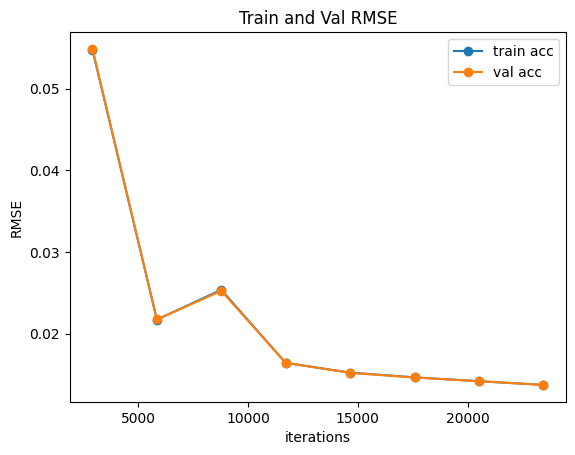

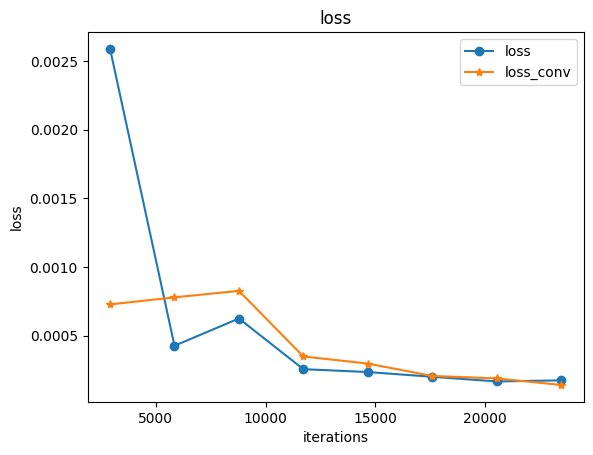

In [73]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')
plt.title('Train and Val RMSE')
plt.plot(iter_history[0:epoch_stop],RMSE_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],RMSE_val_history[0:epoch_stop],'-o')
plt.legend(['train acc','val acc'])
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.show()

plt.title('loss')
plt.plot(iter_history[0:epoch_stop],loss_history[0:epoch_stop],'-o')
plt.plot(iter_history[0:epoch_stop],loss_history_conv[0:epoch_stop],'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

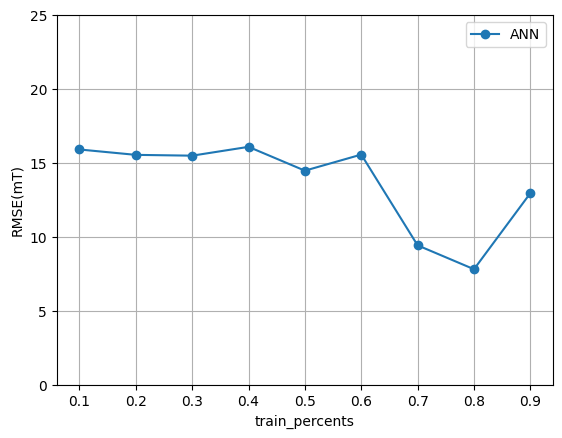

In [72]:
plt.plot(train_percents,RMSE_val_history_end*1000,'-o')
plt.xlabel('train_percents')
plt.ylabel('RMSE(mT)')
plt.ylim([0,25])
plt.grid()
plt.legend(['ANN'])
plt.show()

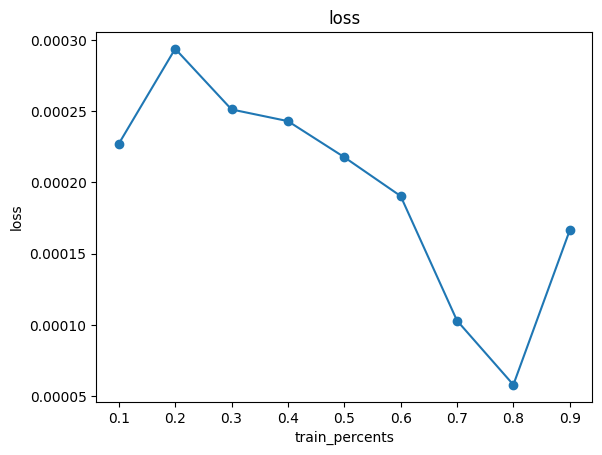

In [66]:
plt.title('loss')
plt.plot(train_percents,loss_history_end,'-o')
plt.xlabel('train_percents')
plt.ylabel('loss')
plt.show()